# Investigating HTAN scRNA-seq with BigQuery

```
Title:   Investigating HTAN scRNA-seq with BigQuery
Author:  Dar'ya Y. Pozhidayeva (dpozhida@systemsbiology.org)
Created: 2022-6-30
Purpose: Explore single cell RNA seq data in HTAN.
URL:    NA
Notes:  NA
```

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Investigating_Single_Cell_HTAN_Data.ipynb)

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer Moonshot<sup>SM</sup> initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ([Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469) )

This notebook shows examples of how HTAN single cell RNA sequencing data can be accessed and analyzed using Python.

### 1.1 Notebook Goal

The goal of this notebook is to show users how public HTAN single cell data can be queried and assembled for further processing. The total time for this tutorial should be about **20 minutes**.

### 1.2 Inputs, Outputs, & Data

The input for this analysis is the HTAN single cell RNA sequencing data (Level 4, gene summarized). The data set is filtered according to a specific cell type and patient population. The data is pulled into this notebook a google cloud connection.



Details regarding the data used:

Data was derived in April 2023 from an H5AD file (Synapse ID: syn51297089) submitted by the MSK HTAN Center. This data set contains both raw gene expression counts and log2(X+1) transformed, median-normalized expression from 62 pooled samples (N=147,137 cells). Data was generated using the 10X Genomics and was processed using SEQC, where reads were mapped to HG38, followed by cell filtering for mitochondrial fraction > 20%, empty droplet filtering (scCB2), and doublet removal (doubletdetection). Genes that were expressed in more than 10 cells were retained. Batch correction with fastMNN was performed for subsequent analysis, including UMAP visualization with scanpy and Phenograph clustering. More information available at: https://linkinghub.elsevier.com/retrieve/pii/S1535610821004979


# 2. Environment & Module Setup
The libraries used in this analysis fall into two categories: those needed for google cloud connection and those needed for the analysis itself.

In [53]:
#If running in google colab, you may have to run the following.
!pip install scanpy
!pip install matplotlib==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


  Using cached matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.3 which is incompatible.
mizani 0.9.2 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.
plotnine 0.12.2 requires matplotlib>=3.6.0, but you have matplotlib 3.1.3 which is incompatible.
scanpy 1.9.3 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


In [52]:
# Data Analytics
import numpy as np
from scipy import stats
from scipy import sparse
import seaborn as sns

The following snipet controls plotting parameters.

In [54]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

In [56]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()
# alternatively, use the gcloud SDK
#!gcloud auth application-default login

In [57]:
# Alternatively, if you're running the notebook locally,
# on the command line use "gcloud auth application-default login"
# to generate a key, take note of where your credentials are saved
# and set the GOOGLE_APPLICATION_CREDENTIALS environment variable using
# the jupyter magic command "%env GOOGLE_APPLICATION_CREDENTIALS=<path to key>"
# then import "from google.cloud import bigquery"
# and you can continue to creating the BigQuery client below.

In [58]:
## Setup ##
# set the google project that will be referenced for this notebook's computations
google_project = 'my-project'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

# 4. Querying data from BigQuery

By accessing the HTAN-joined tables, we can see cell, gene, and count data combined into one table.

## 4.1 Samples and Cells Per Development Stage of Participant

First we can look at the number of samples by some demographics of interest. The data comes from the MSK scRNAseq table found in HTAN isb-cgc-bq.

Let's begin with unique attribute counts by development stage:

In [104]:
df1 = client.query("""
  SELECT
    development_stage,
    count(distinct(iObs)) Number_Cells,
    count(distinct(sex)) Unique_Sex_Grouping,
    count(distinct(donor_id)) Number_Samples,
    count(distinct(cell_type)) Number_Cell_Types,
    count(distinct(treatment)) Number_Therapies
  FROM
  `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
  GROUP BY 1
  ORDER BY Number_Samples DESC # ASC # or DESC
    """).result().to_dataframe()

df1

,development_stage,Number_Cells,Unique_Sex_Grouping,Number_Samples,Number_Cell_Types,Number_Therapies
0,74-year-old human stage,19763,2,4,10,1
1,70-year-old human stage,8060,2,3,10,3
2,68-year-old human stage,10800,1,3,10,3
3,64-year-old human stage,9933,2,3,10,3
4,65-year-old human stage,8718,1,3,11,2
5,67-year-old human stage,5255,1,2,11,2
6,76-year-old human stage,4361,1,2,10,1
7,80-year-old human stage,10998,2,2,11,2
8,69-year-old human stage,4148,2,2,9,2
9,55-year-old human stage,10283,2,2,11,1


Notice, from the aggregate table above, that not all development stage groups have the same number of samples, sex groupings, cell types, or treatments.

Let's plot two of these attributes and get a visual representation of some counts per development stage.

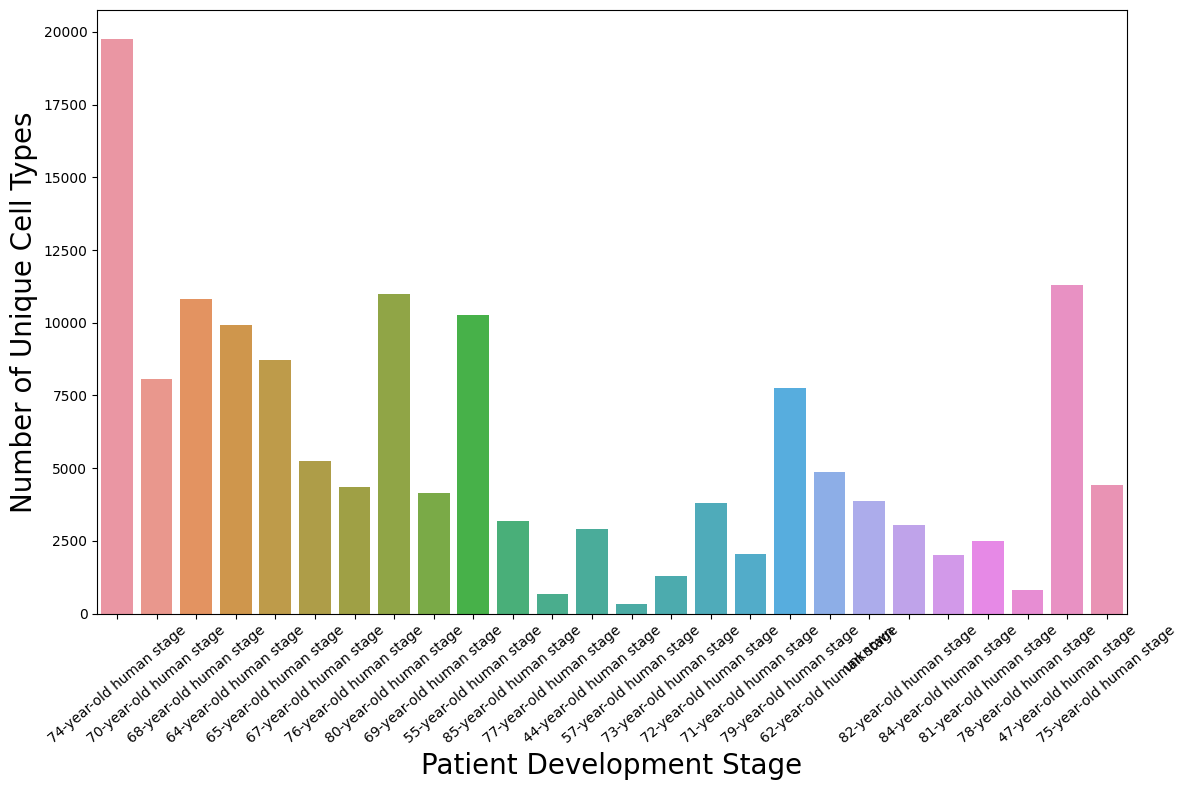

In [113]:
plt.rcParams['figure.figsize'] = [12, 8]

p = sns.barplot(x=df1.development_stage, y=df1.Number_Cells)
p.set_xlabel("Patient Development Stage", fontsize = 20)
p.set_ylabel("Number of Unique Cell Types", fontsize = 20)
plt.xticks(rotation=40)
plt.tight_layout()

Based on this plot, we see that there are some notable differences in cell counts based on the different development stages per sample. It appears that the 74-year-old human stage has  the largest number of unique cells within their available samples. This group also has a large variety of cell types along with the largest number of samples.

This aggregate table and figure can help provide some context for our analysis based on some groups of interest. Limitations in cell types and demographics will impact the sort of analysis that can be performed and how generalizable the results are.

For the sake of this analysis, let's assume that we are interested in comparing the same cell types between two sexes from the same development stage (irrespective of treatment).

Looking at the table and plot, we will isolate the 74-year-old human stage. This is a good option, because this group has a number of samples, two sex types (male and female), and many unique cell types as shown above.

In [107]:
df2 = client.query("""
  SELECT
    cell_type,
    count(distinct(sex)) Unique_Sex_Grouping,
    count(distinct(iObs)) Number_Cells,
    count(distinct(donor_id)) Number_Samples,
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
  WHERE
    development_stage = '74-year-old human stage'
  GROUP BY 1
    """).result().to_dataframe()

df2

,cell_type,Unique_Sex_Grouping,Number_Cells,Number_Samples
0,B cell,2,294,4
1,epithelial cell,2,11674,4
2,plasma cell,2,22,3
3,macrophage,2,2257,4
4,mast cell,2,307,4
5,dendritic cell,2,293,4
6,endothelial cell,2,150,3
7,T cell,2,4390,4
8,neutrophil,1,6,2
9,fibroblast,2,370,4


Now we see above that within this age, there are two genders available for most
cell types. However, we will avoid neutrophils given that it is only represented by one.

Next we decide that we can select the cell type that contains a roughly equal breakdown for sex groupings in terms of cell counts.

In [120]:
df3 = client.query("""
  SELECT
  sex,
  Cell_Type,
  count(distinct(feature_name)) Number_Genes,
    count(distinct(iObs)) Number_Cells,
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
  WHERE development_stage = '74-year-old human stage'
  GROUP BY 1,2
  ORDER BY Cell_Type DESC # ASC # or DESC
    """).result().to_dataframe()

df3

,sex,Cell_Type,Number_Genes,Number_Cells
0,male,plasma cell,4570,4
1,female,plasma cell,8052,18
2,female,neutrophil,3288,6
3,female,mast cell,12571,301
4,male,mast cell,3610,6
5,male,macrophage,13575,78
6,female,macrophage,17219,2179
7,female,fibroblast,15126,339
8,male,fibroblast,11765,31
9,female,epithelial cell,19818,3280


Although they are not even counts, epithelial cells appear to be the best case in this example because they are bountiful for each group compared to other cell types.

[Text(0.5, 1.0, 'Gender and Cell Type')]

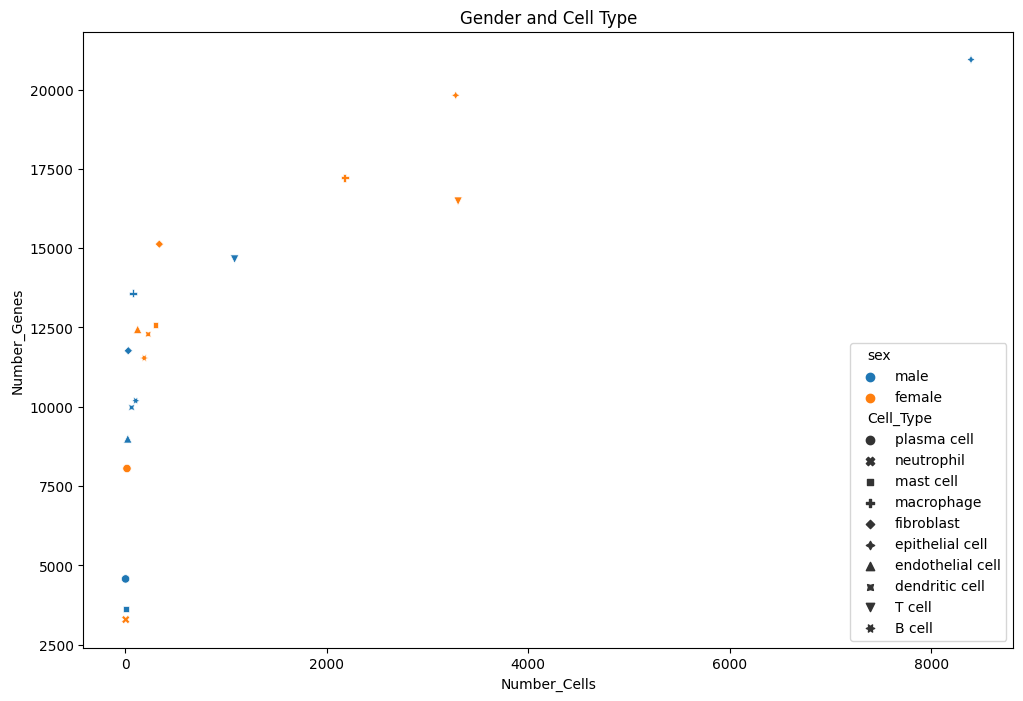

In [118]:
sns.scatterplot(data=df3, x='Number_Cells', y='Number_Genes', hue='sex', style='Cell_Type').set(title='Gender and Cell Type')

Next, once we select a cell type to focus on, we can also explore the Seurat Clusters generated for this data set. Maybe we are interested in comparing between males and females for the same cluster.

The following lines illustrate how to filter and check these clusters:

In [126]:
df4 = client.query("""
  SELECT
  sex,
  clusters,
  Cell_Type,
  count(distinct(feature_name)) Number_Genes,
  count(distinct(iObs)) Number_Cells,
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
  WHERE development_stage = '74-year-old human stage' AND Cell_Type = 'epithelial cell'
  GROUP BY 1,2,3
  ORDER BY clusters ASC # ASC # or DESC
    """).result().to_dataframe()

df4

,sex,clusters,Cell_Type,Number_Genes,Number_Cells
0,female,1,epithelial cell,14501,107
1,male,1,epithelial cell,13086,30
2,female,10,epithelial cell,7793,71
3,male,10,epithelial cell,14491,495
4,female,11,epithelial cell,11328,38
5,male,11,epithelial cell,17560,717
6,female,16,epithelial cell,7589,153
7,male,16,epithelial cell,9507,42
8,male,21,epithelial cell,17532,957
9,female,21,epithelial cell,14423,122


In this analysis, it might be interesting to compare cluster 41 between males and females. How do they differ in terms of gene expression?

## 4.2 Compare monocyte gene expression among clusters

Let's compare cluster 41 in the epithelial cells for males vs. females using their gene expression.

In [130]:
df5 = client.query("""
  SELECT
    sex,
    clusters,
    count(distinct(iObs)) as num_cells_clust10,
    feature_name,
    AVG(X_value) as avg_counts_clust10
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
  WHERE development_stage = '74-year-old human stage' AND Cell_Type = 'epithelial cell' AND clusters = '41'
  GROUP BY 1,2,4
  ORDER BY avg_counts_clust10 DESC
  LIMIT 10
    """).result().to_dataframe()

df5

,sex,clusters,num_cells_clust10,feature_name,avg_counts_clust10
0,female,41,17,SEC11C,5.129833
1,male,41,18,PTMA,5.065770
2,female,41,17,PTMA,4.964546
3,female,41,17,GRP,4.809140
4,male,41,18,H3-3A,4.792233
5,male,41,18,ACTG1,4.540069
6,female,41,17,EEF1A1,4.515069
7,female,41,17,FTH1,4.505147
8,female,41,17,TUBA1A,4.479870
9,male,41,18,H3-3B,4.471539


In the table above, we're interested in comparing the average expression values for genes between the genders shown.

To do this, we're going to make two aggregate tables for each gender and join them on the overlapping genes of interest.

In [132]:
df6 = client.query("""

SELECT
  A.feature_name,
  A.avg_counts_clust10,
  B.avg_counts_clust10,
  A.avg_counts_clust10 - B.avg_counts_clust10 as mean_diff
FROM (
  SELECT
    feature_name,
    AVG(X_value) AS avg_counts_clust10
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
  WHERE development_stage = '74-year-old human stage' AND Cell_Type = 'epithelial cell' AND clusters = '41' AND sex = 'female'
  GROUP BY
    1) AS A
INNER JOIN (
  SELECT
    feature_name,
    AVG(X_value) AS avg_counts_clust10
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_combined_samples_current`
  WHERE development_stage = '74-year-old human stage' AND Cell_Type = 'epithelial cell' AND clusters = '41' AND sex = 'male'
  GROUP BY
    1) AS B
ON
  A.feature_name = B.feature_name
GROUP BY 1,2,3
ORDER BY mean_diff DESC
LIMIT 200

    """).result().to_dataframe()

df6

,feature_name,avg_counts_clust10,avg_counts_clust10_1,mean_diff
0,COTL1,4.195276,0.921154,3.274122
1,GRP,4.809140,1.848121,2.961019
2,HSPA1A,4.064807,1.275329,2.789478
3,HSPA1B,2.994970,0.595447,2.399523
4,DNAJB1,3.017110,0.738918,2.278192
...,...,...,...,...
195,LINC01018,0.853573,0.366214,0.487359
196,MBNL3,0.787354,0.300398,0.486957
197,ATF4,1.332664,0.846229,0.486435
198,CAMK2B,1.369153,0.884848,0.484305


In this way, we can calculate the mean difference of expression between the genes between the genders for the age, cell types and cluster we selected earlier.

We also plot the data like so:

<Axes: ylabel='mean_diff'>

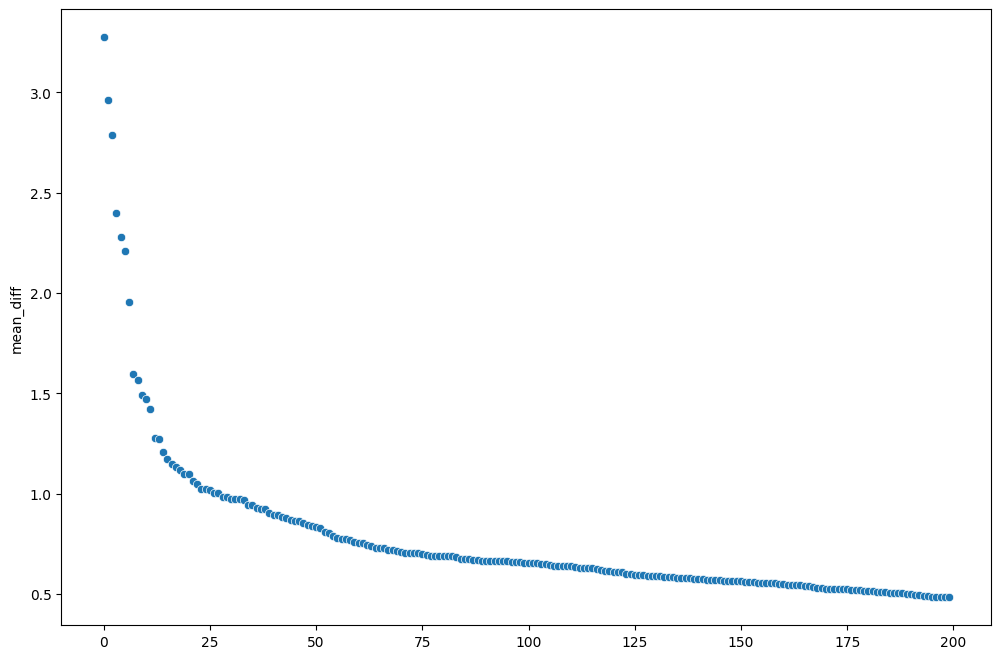

In [133]:
sns.scatterplot(data=df6, x=range(0,200), y='mean_diff')


This allows us to see that there are mean differences of expression for the genes between males and females.

In this case the gene with the highest mean difference in this analysis is
COTL1 (Coactosin Like F-Actin Binding Protein 1). This is a Protein Coding gene. Diseases associated with COTL1 include Lung Cancer and Clivus Chordoma. Among its related pathways are Innate Immune System. Gene Ontology (GO) annotations related to this gene include enzyme binding and actin binding.

In this notebook, we explored the data and compared the gene expression of a specific cell type between gendered samples that can be found within the HTAN CHOP data. This is meant as an example rather than a concrete analysis, so try these steps out yourself!


# 5. Relevant Citations and Links

[HTAN Portal](https://humantumoratlas.org/)

[Overview paper, Cell, April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)

[MSK Data Used](https://linkinghub.elsevier.com/retrieve/pii/S1535610821004979)

